<a href="https://colab.research.google.com/github/sasan73/Mangaka-Classifier/blob/master/Mangaka_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mangaka** *Classifier*


  Using cached https://files.pythonhosted.org/packages/13/70/54e9fb010fe1547bc4774716f11ececb81ae5b306c05f090f4461ee13205/torch-1.5.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1


In [1]:
import torch 
print(torch.__version__)

1.6.0+cu101


In [151]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# folder = "Eiichiro Oda"
# file = "one-piece.csv"

In [ ]:
# folder = "Yoshihiro Togashi"
# file = "hunter-x-hunter.csv"

In [ ]:
# folder = "Hajime Isayama"
# file = "shingeki-no-kyojin.csv"

In [ ]:
# folder = "Koyoharu Gotouge"
# file = "kimetsu-no-yaiba.csv"

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
from pathlib import Path
path = Path('/content/drive/My Drive/Data/Mangaka Classification')

In [ ]:
# dest = path/folder
# dest.mkdir(parents=True, exist_ok=True)

In [ ]:
# path.ls()

In [ ]:
# download_images??

In [ ]:
# download_images(Path('/content/')/file, dest)

In [ ]:
# for c in classes:
    # print(c)
    # verify_images(path/c, delete=True, max_size=500)

(319, 158)


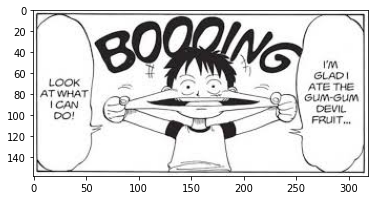

In [64]:
img = Image.open('/content/drive/My Drive/Data/Mangaka Classification/Eiichiro Oda/00000056.jpg')
plt.imshow(img)
print(img.size)

In [123]:
tfms_train = transforms.Compose([transforms.RandomResizedCrop(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(), 
                                transforms.ToTensor(),
                                transforms.Normalize(0, 1)])

tfms_valid = transforms.Compose([transforms.Resize((256, 256)),
                                 transforms.Grayscale(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(0, 1)])

In [124]:
class Mydataset(Dataset):
  def __init__(self, subset, transforms = None):
    self.subset = subset
    self.transforms = transforms
  
  def __getitem__(self, indx):
    x, y = self.subset[indx]
    if self.transforms:  
      x = self.transforms(x)
    return x, y-1
  def __len__(self):
    return len(self.subset)

dataset = datasets.ImageFolder(path)

split_len = [int(len(dataset)* .8), int(len(dataset)* .2)]
train_sub, valid_sub = random_split(dataset, split_len)

train_ds = Mydataset(train_sub, transforms = tfms_train)
valid_ds = Mydataset(valid_sub, transforms = tfms_valid)

In [125]:
lst = []
for i in range(len(valid_ds)):
  lst.append(valid_ds[i][1])
print(len(lst))

294


In [126]:
batch = 64

In [127]:
train_dl = DataLoader(train_ds, batch_size = batch, shuffle = False, num_workers = 4)
valid_dl = DataLoader(valid_ds, batch_size = batch, shuffle = False, num_workers = 4)

In [128]:
data = load_data(path, 'data')

NameError: ignored

In [129]:
for i, (x, y) in enumerate(valid_dl):
  print(f"batch number: {i}", x.shape)
  print(y.shape)
  print('-' * 10)

batch number: 0 torch.Size([64, 1, 256, 256])
torch.Size([64])
----------
batch number: 1 torch.Size([64, 1, 256, 256])
torch.Size([64])
----------
batch number: 2 torch.Size([64, 1, 256, 256])
torch.Size([64])
----------
batch number: 3 torch.Size([64, 1, 256, 256])
torch.Size([64])
----------
batch number: 4 torch.Size([38, 1, 256, 256])
torch.Size([38])
----------


# Data Visualisation

In [130]:
data.show_batch(rows=3, figsize=(7,8))

TypeError: ignored

# Learning Process

In [131]:
def conv_layer(in_c, out_c, k, stride=1): return nn.Sequential(nn.Conv2d(in_c, out_c, k, stride, padding=1),
                                          nn.ReLU(),
                                          nn.BatchNorm2d(out_c))

class res_block(nn.Module):
   def __init__(self, c, k):
     super().__init__()
     self.conv1 = conv_layer(c, c, k)
     self.conv2 = conv_layer(c, c, k)
   def forward(self, x): 
     return x + self.conv2(self.conv1(x))

class global_avpool(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x): 
    num_dim = len(x.shape)
    return x.mean([num_dim - 1, num_dim - 2])

In [132]:
manga_net = nn.Sequential(conv_layer(1, 64, 5, stride = 2),
                          res_block(64, 3),
                          nn.MaxPool2d(2),
                          conv_layer(64, 128, 3, stride= 2),
                          nn.MaxPool2d(2),
                          res_block(128, 3),
                          global_avpool(),
                          nn.Linear(128, 4))

In [133]:
net = manga_net.cuda()

In [140]:
lr = 1e-2
EPOCH = 6
i = 0
momentum = 0.9

In [148]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [156]:
for epoch in range(EPOCH):  # loop over the dataset multiple times
    net.train()
    k = 0
    running_loss_train = 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.cuda(), labels.cuda() 


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss_train = criterion(outputs, labels)
        loss_train.backward()
        optimizer.step()

        running_loss_train += loss_train.item()
        k += 1
    print(f'epoch:{epoch}\t\t training_loss: {running_loss_train/ k}')
    
    
    net.eval()
    k = 0     
    running_loss_valid = 0
    corr_cls = 0
    for j, (inputs, labels)  in enumerate(valid_dl):
        with torch.no_grad():
          inputs, labels = inputs.cuda(), labels.cuda()
          outputs = net(inputs)
          loss_valid = criterion(outputs, labels) 
          # calculating evaluation stats
          running_loss_valid += loss_valid.item()
          k += 1
          
          _, preds = torch.max(F.softmax(outputs, 1), 1)
          corr_cls += (preds == labels).sum().item()
                
    print(f'epoch:{epoch}\t\t validation_loss: {running_loss_valid/ k}')
    print(f'epoch:{epoch}\t\t accuracy:{corr_cls * 100 /len(valid_ds)}')   
    print('-' * 20)

print('Finished Training')

epoch:0		 training_loss: 0.8244839938063371
1176
epoch:0		 validation_loss: 1.325731873512268
epoch:0		 accuracy:55.10204081632653
--------------------
epoch:1		 training_loss: 0.8188377618789673
1176
epoch:1		 validation_loss: 1.2261343002319336
epoch:1		 accuracy:58.50340136054422
--------------------
epoch:2		 training_loss: 0.8619492461806849
1176
epoch:2		 validation_loss: 1.1101964354515075
epoch:2		 accuracy:61.564625850340136
--------------------
epoch:3		 training_loss: 0.8067999074333593
1176
epoch:3		 validation_loss: 1.0444918155670166
epoch:3		 accuracy:62.244897959183675
--------------------
epoch:4		 training_loss: 0.7897348090222007
1176
epoch:4		 validation_loss: 1.2579915523529053
epoch:4		 accuracy:56.12244897959184
--------------------
epoch:5		 training_loss: 0.7712549190772208
1176
epoch:5		 validation_loss: 1.3607955932617188
epoch:5		 accuracy:55.78231292517007
--------------------
Finished Training


In [43]:
PATH = '/content/drive/My Drive/Data/Mangaka Classification/models/stage1.pth'
torch.save(net.state_dict(), PATH)

In [45]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
torch.cuda.empty_cache()

# Transfer Learning

In [159]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [162]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloaders = train_dl
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders = valid_dl

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            if phase == 'train':
                epoch_loss = running_loss / len(train_ds) 
                epoch_acc = running_corrects.double() / len(train_ds)
            else:
                epoch_loss = running_loss / len(valid_ds) 
                epoch_acc = running_corrects.double() / len(valid_ds)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [165]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(net, criterion, optimizer, exp_lr_scheduler, num_epochs=5);

Epoch 0/4
----------
train Loss: 0.6752 Acc: 0.7355
val Loss: 0.7212 Acc: 0.7517

Epoch 1/4
----------
train Loss: 0.6462 Acc: 0.7330
val Loss: 1.0476 Acc: 0.6497

Epoch 2/4
----------
train Loss: 0.6525 Acc: 0.7355
val Loss: 0.7227 Acc: 0.7517

Epoch 3/4
----------
train Loss: 0.6613 Acc: 0.7500
val Loss: 1.1662 Acc: 0.5714

Epoch 4/4
----------
train Loss: 0.6527 Acc: 0.7313
val Loss: 1.0157 Acc: 0.6429

Training complete in 0m 25s
Best val Acc: 0.751701
